# Asymptotic stabilization of an unstable pendulum 

Given the system specifications, we define the parameters as $m = 1\text{kg}$, $M = 10\text{kg}$, $l = 1\text{m}$, and $g = 9.81\text{ms}^{-2}$. In order to determine the value of $S$, we employ the arec(A,G,Q) function from the MatrixEquations package in Julia. It is imperative to recognize that $G = BR^{-1}B^T$.

In [1]:
using MatrixEquations, PrettyTables, LinearAlgebra

m = 1.0
M = 10.0
l = 1.0
g = 9.81
r = 1.0

mass_inv = inv([(m+M) (-m*l);(-m*l) (m*l^2)])
zero = zeros(2, 2)

A = [zero Matrix(I, 2, 2); (mass_inv * [0 0;0 (m*g*l)]) zero]
B = [0; 0; 1/(M+m); -1/(M*l)]

Q = Matrix(I, 4, 4)

G = B * (1/r) * B'

solution = arec(A, G, Q)
S = solution[1]

pretty_table(S, crop=:none)

┌─────────┬─────────┬─────────┬─────────┐
│  Col. 1 │  Col. 2 │  Col. 3 │  Col. 4 │
├─────────┼─────────┼─────────┼─────────┤
│ 5.18956 │ 75.0038 │ 12.9658 │ 21.7871 │
│ 75.0038 │ 9342.16 │  367.45 │ 2812.28 │
│ 12.9658 │  367.45 │ 60.3362 │ 106.747 │
│ 21.7871 │ 2812.28 │ 106.747 │  847.08 │
└─────────┴─────────┴─────────┴─────────┘


### State Trajectory and Control Signal Simulation

**Initial Condition**:
$$ 
x(0) = \begin{bmatrix} 0 \\ 0.1 \\ 0 \\ 0 \end{bmatrix} 
$$

Using the derived solution for \(S\), we are going to determine the optimal control signal:
$$ 
u = F(x) 
$$

and simulate the state trajectory \(x(t)\) and the control signal \(u(t)\) for the time interval:
$$ 
t \in [0,60] 
$$

After this, we are generating plots showcasing these trajectories over the defined duration. To wrap up, we are going to evaluate the objective function \(V\) using the given \(x,u\). Instead of an indefinite period, we will focus on the mentioned finite interval.


In [2]:
using DifferentialEquations, Plots, QuadGK

function pendulum_dynamics!(dx, x, p, t)
    u = -inv(r) * B' * S * x
    dx .= A * x + B * u
end

x0 = [0.0, 0.1, 0.0, 0.0]
tspan = (0.0, 60.0)

(0.0, 60.0)

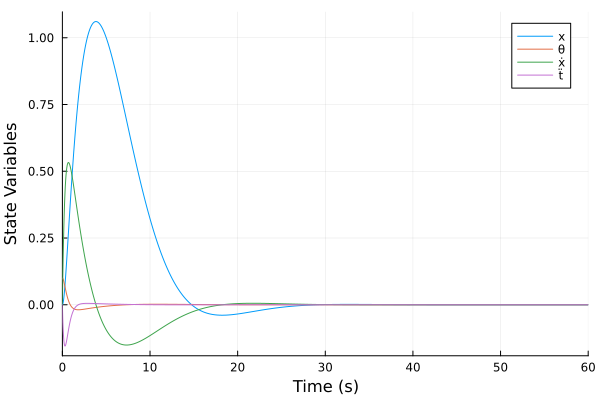

In [3]:
problem = ODEProblem(pendulum_dynamics!, x0, tspan)
solution = solve(problem, Tsit5(), reltol=1e-8, abstol=1e-8)

plot(solution, xlabel="Time (s)", ylabel="State Variables", lw=1, label=["x" "θ" "ẋ" "ẗ"])
#savefig("./figures/state_trajectory.png")

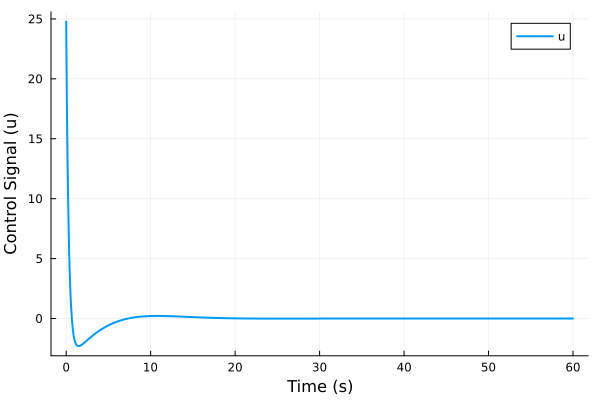

In [4]:
function control_signal(t, x)
    -inv(r) * B' * S * x
end

u_values = [control_signal(t, solution(t)) for t in solution.t]
plot(solution.t, u_values, xlabel="Time (s)", ylabel="Control Signal (u)", lw=2, label="u")
#savefig("./figures/control_signal.png")

These are the main observations regarding the figures:

1. The pendulum angle ($\theta$) converges to $0$, which means that the controller is successful in stabilizing the pendulum in the upright position.
2. The cart position ($x$) also converges to $0$, meaning that the controller maintains the cart at the desired location.
3. The velocity ($\dot{x}$) approaches $0$ as well, indicating that the system is stabilizing without significant oscillations.
4. The control signal $u(t)$ decreases in magnitude as the system approaches the equilibrium state. That's the case since it expresses a pattern of applying force when needed to maintain stability.

The observations demonstrate that the controller is effectively directing the system towards the unstable equilibrium point while minimizing control effort, ultimately resulting in stable behavior and energy-efficient control.

In [5]:
function objective_integrand(t)
    x = solution(t)
    u = control_signal(t, x)
    x' * Q * x + u' * r * u
end

V, _ = quadgk(objective_integrand, tspan[1], tspan[2])
println("Objective V: ", V)

Objective V: 93.4215901911255


The objective function's value $V = 93.421$ represents the deviation from the equilibrium state and the control effort spent over the time interval of $0$ to $60$ seconds.

### Assessment of Control Strategy Optimality

To examine the efficacy of the derived control strategy, we are going to construct at least five distinct control policies:
$$ 
u_i = F_i(x) 
$$
and simulate the system for each policy over the same time interval. Subsequently, we are evaluating the objective function for each of these strategies and make comparisons with the value obtained in the preceding section.

For the control strategy, a simple approach is:
$$ 
u = -R^{-1}B^T S'x 
$$
where \(S'\) is a $4x4$ matrix resulting from random variations of the entries in \(S\) derived in earlier steps.

In [6]:
using DifferentialEquations, Random, LinearAlgebra, QuadGK

function perturbed_system(dx, x, params, t)
    A, B, R_inv, S_prime = params
    u = -R_inv * B' * S_prime * x
    dx .= A * x .+ B * u
end

function objective_value(sol, R, Q)
    function integrand(t)
        x_t = sol(t)
        u_t = -inv(R) * B' * S * x_t
        return (x_t' * Q * x_t + u_t' * R * u_t)[1]
    end
    V, _ = quadgk(integrand, sol.t[1], sol.t[end], rtol=1e-8, atol=1e-8)
    return V
end

num_policies = 5
obj_values = zeros(num_policies)

for i in 1:num_policies
    S_prime = S .+ 0.1 * randn(size(S))
    params = (A, B, inv(r), S_prime)
    prob_perturbed = ODEProblem(perturbed_system, x0, tspan, params)
    sol_perturbed = solve(prob_perturbed, Tsit5(), reltol=1e-8, abstol=1e-8)
    obj_values[i] = objective_value(sol_perturbed, r, Q)
end

println("Objective values for perturbed policies: ", obj_values)

Objective values for perturbed policies: [93.50256716775563, 93.28008207404055, 93.38659696292386, 93.48822328821944, 93.61775636635625]


Given the objective values for the perturbed policies, we observe that all five of them are extremely close to the objective value of the original optimal control policy ($93.421$). 

This suggests that the optimal control policy is very robust and not overly sensitive to small perturbations in the $S$ matrix.


### Impact of Car's Mass on Stabilization

To understand the influence of the car's mass on the stabilization challenge, we are going to evaluate the system for two specific masses:
$$ 
M = 20\text{kg} \quad \text{and} \quad M = 5\text{kg} 
$$
Keeping all other parameters constant, we will revisit the earlier tasks. We are going to see how the value of \(V\) for these cases contrast with the initial scenario where \(M = 10kg\).


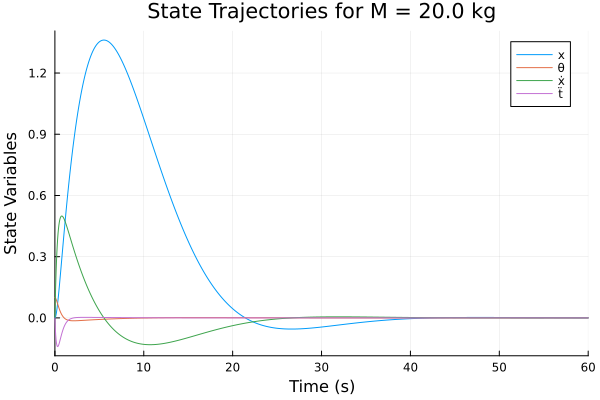

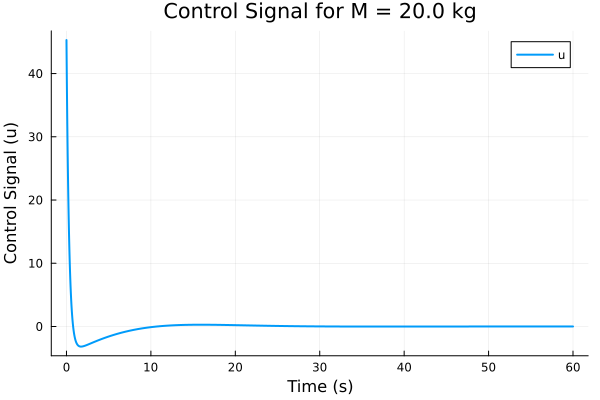

S matrix for M = 20.0 kg:


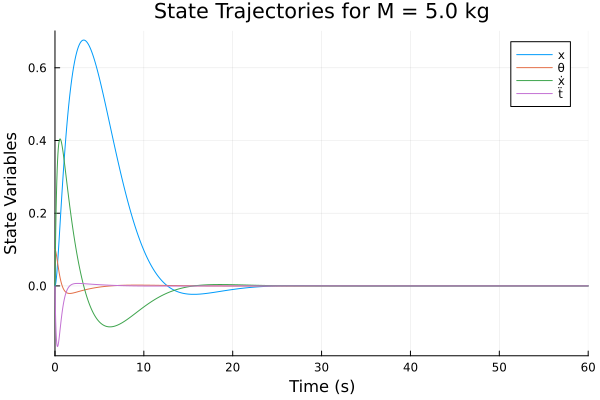

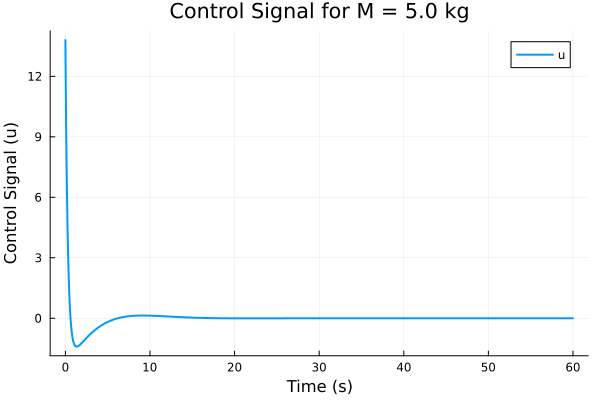

┌─────────┬─────────┬─────────┬─────────┐
│  Col. 1 │  Col. 2 │  Col. 3 │  Col. 4 │
├─────────┼─────────┼─────────┼─────────┤
│ 7.33962 │ 141.464 │  26.435 │ 45.1762 │
│ 141.464 │ 31975.5 │ 993.118 │ 10005.6 │
│  26.435 │ 993.118 │ 178.881 │ 317.155 │
│ 45.1762 │ 10005.6 │ 317.155 │ 3131.34 │
└─────────┴─────────┴─────────┴─────────┘
Objective V for M = 20.0 kg: 319.75495951361734


S matrix for M = 5.0 kg:


┌─────────┬─────────┬─────────┬─────────┐
│  Col. 1 │  Col. 2 │  Col. 3 │  Col. 4 │
├─────────┼─────────┼─────────┼─────────┤
│ 4.51242 │ 40.8195 │ 9.68096 │ 13.0675 │
│ 40.8195 │  2782.5 │ 171.127 │ 832.615 │
│ 9.68096 │ 171.127 │ 38.6913 │ 54.8048 │
│ 13.0675 │ 832.615 │ 54.8048 │ 249.768 │
└─────────┴─────────┴─────────┴─────────┘
Objective V for M = 5.0 kg: 27.824982629318853




In [7]:
using MatrixEquations, PrettyTables, DifferentialEquations, Plots, QuadGK

#different masses
M_values = [20.0, 5.0]

for M in M_values
    #update system matrices
    A = [0 0 1 0;
         0 0 0 1;
         0 -m*g/(M+m) 0 0;
         0 (M+m)*g/(M*l) 0 0]
    B = [0; 0; 1/(M+m); -1/(M*l)]

    #ricatti's equation
    G = B * (1/r) * B'
    solution = arec(A, G, Q)
    S = solution[1]

    println("S matrix for M = $M kg:")
    pretty_table(S, crop=:none)

    x0 = [0.0, 0.1, 0.0, 0.0]
    tspan = (0.0, 60.0)

    problem = ODEProblem(pendulum_dynamics!, x0, tspan)
    solution = solve(problem, Tsit5(), reltol=1e-8, abstol=1e-8)

    state_plot = plot(solution, xlabel="Time (s)", ylabel="State Variables", lw=1, label=["x" "θ" "ẋ" "ẗ"])
    title!("State Trajectories for M = $M kg")
    display(state_plot)
    # savefig("./figures/state_trajectory_M_$M.png")

    #control signals
    function control_signal(t, x)
        -inv(r) * B' * S * x
    end
    u_values = [control_signal(t, solution(t)) for t in solution.t]

    control_plot = plot(solution.t, u_values, xlabel="Time (s)", ylabel="Control Signal (u)", lw=2, label="u")
    title!("Control Signal for M = $M kg")
    display(control_plot)
    # savefig("./figures/control_signal_M_$M.png")

    #objective value
    function objective_integrand(t)
        x = solution(t)
        u = -inv(r) * B' * S * x
        x' * Q * x + u' * r * u
    end

    V, _ = quadgk(objective_integrand, tspan[1], tspan[2])
    println("Objective V for M = $M kg: ", V)
    println("\n")
end

For the different car masses, we get:

- For $M = 20.0 kg$: $V = 319.754$
- For $M = 10.0 kg$ (original case): $V = 93.421$
- For $M = 5.0 kg$: $V = 27.824$

As already analyzed, smaller values of $V$ indicate better stabilization, as $V$ represents the deviation of the state variables from their desired values and the control effort.

In this case, a larger car mass (M = 20.0 kg) makes stabilization much more challenging, as the value of $V$ is more than three times higher compared to the original case (M = 10.0 kg). On the other hand, as expected, a smaller car mass (M = 5.0 kg) results in a better stabilization performance, as the value of $V$ is significantly lower compared to the original case. We can also observe this from the fact that the state variables converge faster in the case of M = 5.0 kg (see plots).


### Evaluating Impact of Pendulum Length on Stabilization

To probe the effect of pendulum length on the stabilization challenge, we are going to analyze the system for two distinct lengths:
$$ 
l = 2\text{m} \quad \text{and} \quad l = 0.5\text{m}
$$ 
With all other parameters staying consistent with the initial setup, we will re-examine the previous tasks. And we are going to see how does the value of \(V\) in these cases contrast with the baseline where $l = 1\text{m}$.

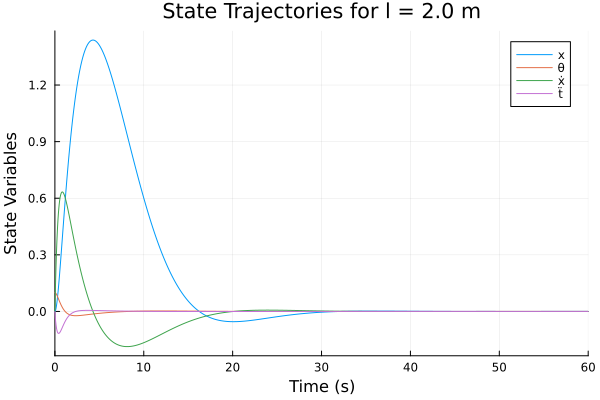

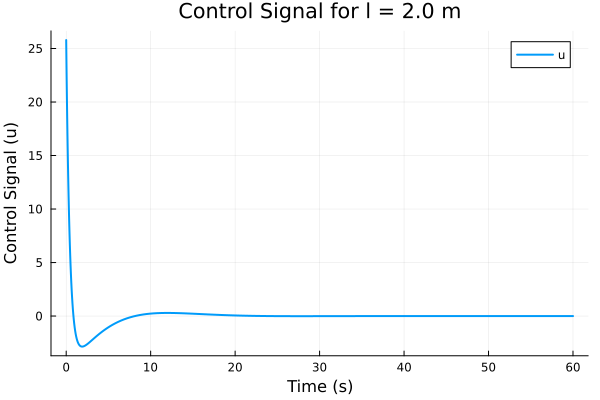

S matrix for l = 2.0 m:
┌─────────┬─────────┬─────────┬─────────┐
│  Col. 1 │  Col. 2 │  Col. 3 │  Col. 4 │
├─────────┼─────────┼─────────┼─────────┤
│   5.885 │ 111.927 │ 16.8166 │ 50.5757 │
│ 111.927 │ 14335.3 │ 608.116 │ 6263.34 │
│ 16.8166 │ 608.116 │ 86.4155 │ 274.819 │
│ 50.5757 │ 6263.34 │ 274.819 │ 2738.21 │
└─────────┴─────────┴─────────┴─────────┘

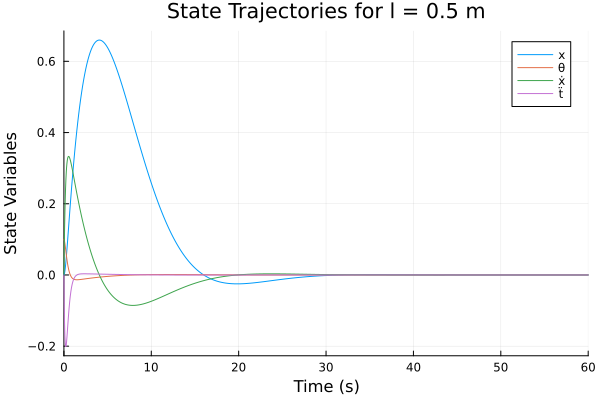

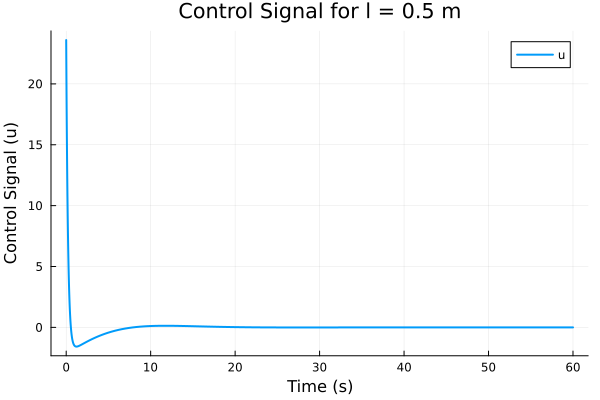


Objective V for l = 2.0 m: 143.3525129658991


S matrix for l = 0.5 m:
┌─────────┬─────────┬─────────┬─────────┐
│  Col. 1 │  Col. 2 │  Col. 3 │  Col. 4 │
├─────────┼─────────┼─────────┼─────────┤
│ 5.45164 │ 51.0211 │ 14.3602 │ 11.5274 │
│ 51.0211 │ 5996.86 │ 266.621 │ 1301.08 │
│ 14.3602 │ 266.621 │ 72.5656 │ 60.2426 │
│ 11.5274 │ 1301.08 │ 60.2426 │ 282.488 │
└─────────┴─────────┴─────────┴─────────┘


Objective V for l = 0.5 m: 59.96857137691809




In [ ]:
using MatrixEquations, PrettyTables, DifferentialEquations, Plots, QuadGK
\(l = 1\text{m}\)
#different lengths
l_values = [2.0, 0.5]

for l in l_values
    #update system matrices
    A = [0 0 1 0;
         0 0 0 1;
         0 -m*g/(M+m) 0 0;
         0 (M+m)*g/(M*l) 0 0]
    B = [0; 0; 1/(M+m); -1/(M*l)]

    #ricatti's equation
    G = B * (1/r) * B'
    solution = arec(A, G, Q)
    S = solution[1]

    println("S matrix for l = $l m:")
    pretty_table(S, crop=:none)

    x0 = [0.0, 0.1, 0.0, 0.0]
    tspan = (0.0, 60.0)

    problem = ODEProblem(pendulum_dynamics!, x0, tspan)
    solution = solve(problem, Tsit5(), reltol=1e-8, abstol=1e-8)

    state_plot = plot(solution, xlabel="Time (s)", ylabel="State Variables", lw=1, label=["x" "θ" "ẋ" "ẗ"])
    title!("State Trajectories for l = $l m")
    display(state_plot)

    u_values = [-inv(r) * B' * S * solution(t) for t in solution.t]
    control_plot = plot(solution.t, u_values, xlabel="Time (s)", ylabel="Control Signal (u)", lw=2, label="u")
    title!("Control Signal for l = $l m")
    display(control_plot)

    #objective value
    function objective_integrand(t)
        x = solution(t)
        u = -inv(r) * B' * S * x
        x' * Q * x + u' * r * u
    end

    V, _ = quadgk(objective_integrand, tspan[1], tspan[2])
    println("Objective V for l = $l m: ", V)
    println("\n")
end

Given the results:

1. For the original case ($l = 1m$): $V = 93.421$
2. For $l = 2m$: $V = 143.352$
3. For $l = 0.5m$: $V = 59.968$

For the longer pendulum, the objective value V is higher compared to the original case, which implies that it is more difficult to stabilize the longer pendulum.

For the shorter pendulum, the objective value V is lower compared to the original case, which indicates that it is easier to stabilize the shorter pendulum.

However, the state variables approach zero in a similar manner in all these cases, despite the difference in objective values (see state variable plots). This indicates that, while the longer pendulum may be more difficult to stabilize in terms of achieving the desired objective value, the overall performance of the system might still be acceptable. Therefore, it's important to not only consider the objective value, but also the behavior of the system as a whole.


### Impact of Initial Angular Displacement

To understand the influence of the initial angular displacement $\theta(0)$ on the optimal value of the objective function $V$, we will vary $\theta(0)$ while maintaining all other parameters constant. We are interested in observing the implications when $\theta(0)$ from equilibrium becomes notably large.|

In [9]:
using MatrixEquations, PrettyTables, DifferentialEquations, Plots, QuadGK

theta0_values = [0.1, 0.5, 1.0, 1.5, 2.0]

for theta0 in theta0_values
    x0 = [0.0, theta0, 0.0, 0.0]
    tspan = (0.0, 60.0)

    problem = ODEProblem(pendulum_dynamics!, x0, tspan)
    solution = solve(problem, Tsit5(), reltol=1e-8, abstol=1e-8)

    #objective value
    function objective_integrand(t)
        x = solution(t)
        u = -inv(r) * B' * S * x
        x' * Q * x + u' * r * u
    end

    V, _ = quadgk(objective_integrand, tspan[1], tspan[2])
    println("For θ(0)=$theta0 rad: V = ", V)
end


For θ(0)=0.1 rad: V = 59.96857137691809


For θ(0)=0.5 rad: V = 1499.2142843459658


For θ(0)=1.0 rad: V = 5996.85713791416


For θ(0)=1.5 rad: V = 13492.928560348642


For θ(0)=2.0 rad: V = 23987.428553276135


Based on the obtained results:

1. For $0.1 rad$:   $V = 59.97$
2. For $0.5 rad$:   $V = 1499.21$
3. For $1.0 rad$:   $V = 5996.85$
4. For $1.5 rad$:   $V = 13492.92$
5. For $2.0 rad$:   $V = 23987.42$

As we see, the optimal value of the objective function increases with the initial angular displacement $θ(0)$. Thus, the larger the initial displacement, the more challenging it becomes to stabilize the system and bring the pendulum back to the unstable equilibrium.

As for the case when the initial angular displacement becomes too large, the linearized model of the system is not accurate. That's because it is only valid only in the vicinity of the unstable equilibrium. In essence, the control strategy we get from the linearized model may not stabilize the system effectively. 

Then, the nonlinear dynamics would need to be considered and incorporated into the model. For a more accurate control, the control design that would be derived by the non-linear model will be significantly more effective; especially for large initial angular displacements.